## 5 July 2018
-- Laurin Gray

Making a 3-sigma curve down a CMD.  We flag any object rightward of the 3-sigma line "of interest".  If a source is flagged in multiple CMDs, we can be more confident that it is an AGB star.

The approach in this notebook is to sort y-values, x-values, error values, and IDs into separate bins/arrays, grouped by magnitude ranges.  We sort by magnitude because as the source becomes dimmer, the error associated with it increases.  We determine the 3-sigma value for each range, and an average line down the main vertical branch to be 3-sigma away from.  We then identify any value that is higher than the 3-sigma boundary for the region it falls into and place the corresponding ID into a new array, which can be compared to other arrays to determine which ones are flagged in multiple CMDs.

The processes in this notebook are not currently efficient for analyzing multiple CMDs, primarily because it is difficult to change the binsize/number.

The data comes from the catalog of Spitzer sources of Khan et al. (2015), matched with sources from Whitelock et al. (2013) in CasJobs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde

In [2]:
# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('~/Documents/Phot_data/CMDparameters26June2018_lauringray.csv')

In [3]:
# Create all color cuts needed for plotting

phot_data['threesixMINUSfourfive'] = phot_data.k36mag.values - phot_data.k45mag.values
phot_data['threesixMINUSfiveeight'] = phot_data.k36mag.values - phot_data.k58mag.values
phot_data['threesixMINUSeightzero'] = phot_data.k36mag.values - phot_data.k80mag.values
phot_data['threesixMINUStwentyfour'] = phot_data.k36mag.values - phot_data.k24mag.values
#
phot_data['fourfiveMINUSfiveeight'] = phot_data.k45mag.values - phot_data.k58mag.values
phot_data['fourfiveMINUSeightzero'] = phot_data.k45mag.values - phot_data.k80mag.values
phot_data['fourfiveMINUStwentyfour'] = phot_data.k45mag.values - phot_data.k24mag.values
#
phot_data['fiveeightMINUSeightzero'] = phot_data.k58mag.values - phot_data.k80mag.values
phot_data['fiveeightMINUStwentyfour'] = phot_data.k58mag.values - phot_data.k24mag.values
#
phot_data['eightzeroMINUStwentyfour'] = phot_data.k80mag.values - phot_data.k24mag.values
#
phot_data['jMINUSthreesix'] = phot_data.Jmag.values - phot_data.k36mag.values
phot_data['jMINUSfourfive'] = phot_data.Jmag.values - phot_data.k45mag.values
phot_data['jMINUSfiveeight'] = phot_data.Jmag.values - phot_data.k58mag.values
phot_data['jMINUSeightzero'] = phot_data.Jmag.values - phot_data.k80mag.values
phot_data['jMINUStwentyfour'] = phot_data.Jmag.values - phot_data.k24mag.values
#
phot_data['hMINUSthreesix'] = phot_data.Hmag.values - phot_data.k36mag.values
phot_data['hMINUSfourfive'] = phot_data.Hmag.values - phot_data.k45mag.values
phot_data['hMINUSfiveeight'] = phot_data.Hmag.values - phot_data.k58mag.values
phot_data['hMINUSeightzero'] = phot_data.Hmag.values - phot_data.k80mag.values
phot_data['hMINUStwentyfour'] = phot_data.Hmag.values - phot_data.k24mag.values
#
phot_data['kMINUSthreesix'] = phot_data.Kmag.values - phot_data.k36mag.values
phot_data['kMINUSfourfive'] = phot_data.Kmag.values - phot_data.k45mag.values
phot_data['kMINUSfiveeight'] = phot_data.Kmag.values - phot_data.k58mag.values
phot_data['kMINUSeightzero'] = phot_data.Kmag.values - phot_data.k80mag.values
phot_data['kMINUStwentyfour'] = phot_data.Kmag.values - phot_data.k24mag.values

In [4]:
# Combine errors

# We want the horizontal error values, so we combine the errors for the two values being subtracted 
# to get the largest possible error bars

phot_data['e_kMINUSthreesix'] = phot_data.eKmag.values + phot_data.e36mag.values

In [5]:
# Some values in the tables are +/- 9999, due to null data from combining the tables, 
# which throws off the color scaling.  We wish to exclude these values, 
# which we do by cutting to only include values in the range -500:500

filter_phot_data = phot_data[(phot_data < 500.0) & (phot_data > -500.0)]

In [6]:
# In this notebook, we are working with the K vs K-[3.6] CMD.  
# Y-range, binsize, and bin number may change depending on the data being accessed

# First binning attempt
# Bin size = 0.5 mag
# Create an empty set for each magnitude range, one for each value we want to parse (x, y, err, ID)

# set up bins as empty sets - bins for x-values
x_elevenfive_twelve = []
x_twelve_twelvefive = []
x_twelvefive_thirteen = []
x_thirteen_thirteenfive = []
x_thirteenfive_fourteen = []
x_fourteen_fourteenfive = []
x_fourteenfive_fifteen = []
x_fifteen_fifteenfive = []
x_fifteenfive_sixteen = []
x_sixteen_sixteenfive = []
x_sixteenfive_seventeen = []
x_seventeen_seventeenfive = []
x_seventeenfive_eighteen = []
x_eighteen_eighteenfive = []

# bins for errors
e_elevenfive_twelve = []
e_twelve_twelvefive = []
e_twelvefive_thirteen = []
e_thirteen_thirteenfive = []
e_thirteenfive_fourteen = []
e_fourteen_fourteenfive = []
e_fourteenfive_fifteen = []
e_fifteen_fifteenfive = []
e_fifteenfive_sixteen = []
e_sixteen_sixteenfive = []
e_sixteenfive_seventeen = []
e_seventeen_seventeenfive = []
e_seventeenfive_eighteen = []
e_eighteen_eighteenfive = []

# bins for coordinates & IDs
c_elevenfive_twelve = []
c_twelve_twelvefive = []
c_twelvefive_thirteen = []
c_thirteen_thirteenfive = []
c_thirteenfive_fourteen = []
c_fourteen_fourteenfive = []
c_fourteenfive_fifteen = []
c_fifteen_fifteenfive = []
c_fifteenfive_sixteen = []
c_sixteen_sixteenfive = []
c_sixteenfive_seventeen = []
c_seventeen_seventeenfive = []
c_seventeenfive_eighteen = []
c_eighteen_eighteenfive = []

# bins to store corresponding y-values
y_elevenfive_twelve = []
y_twelve_twelvefive = []
y_twelvefive_thirteen = []
y_thirteen_thirteenfive = []
y_thirteenfive_fourteen = []
y_fourteen_fourteenfive = []
y_fourteenfive_fifteen = []
y_fifteen_fifteenfive = []
y_fifteenfive_sixteen = []
y_sixteen_sixteenfive = []
y_sixteenfive_seventeen = []
y_seventeen_seventeenfive = []
y_seventeenfive_eighteen = []
y_eighteen_eighteenfive = []

In [7]:
# counter for accessing correct index of column
c=0

# for each element in the list of Kmag values, evaluate which range it belongs to, 
# then add the x-value, error, & ID from the corresponding row to the the bin/array for that range 
# & proceed to the next element

for i in filter_phot_data.Kmag.values:
    if 11.5 <= i < 12.0:
        x_elevenfive_twelve.append(filter_phot_data.kMINUSthreesix.values[c])
        e_elevenfive_twelve.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_elevenfive_twelve.append(phot_data.ID.values[c])
        y_elevenfive_twelve.append(i)
        c = c+1
    elif 12.0 <= i < 12.5:
        x_twelve_twelvefive.append(filter_phot_data.kMINUSthreesix.values[c])
        e_twelve_twelvefive.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_twelve_twelvefive.append(phot_data.ID.values[c])
        y_twelve_twelvefive.append(i)
        c = c+1
    elif 12.5 <= i < 13.0:
        x_twelvefive_thirteen.append(filter_phot_data.kMINUSthreesix.values[c])
        e_twelvefive_thirteen.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_twelvefive_thirteen.append(phot_data.ID.values[c])
        y_twelvefive_thirteen.append(i)
        c = c+1
    elif 13.0 <= i < 13.5:
        x_thirteen_thirteenfive.append(filter_phot_data.kMINUSthreesix.values[c])
        e_thirteen_thirteenfive.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_thirteen_thirteenfive.append(phot_data.ID.values[c])
        y_thirteen_thirteenfive.append(i)
        c = c+1
    elif 13.5 <= i < 14.0:
        x_thirteenfive_fourteen.append(filter_phot_data.kMINUSthreesix.values[c])
        e_thirteenfive_fourteen.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_thirteenfive_fourteen.append(phot_data.ID.values[c])
        y_thirteenfive_fourteen.append(i)
        c = c+1
    elif 14.0 <= i < 14.5:
        x_fourteen_fourteenfive.append(filter_phot_data.kMINUSthreesix.values[c])
        e_fourteen_fourteenfive.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_fourteen_fourteenfive.append(phot_data.ID.values[c])
        y_fourteen_fourteenfive.append(i)
        c = c+1
    elif 14.5 <= i < 15.0:
        x_fourteenfive_fifteen.append(filter_phot_data.kMINUSthreesix.values[c])
        e_fourteenfive_fifteen.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_fourteenfive_fifteen.append(phot_data.ID.values[c])
        y_fourteenfive_fifteen.append(i)
        c = c+1
    elif 15.0 <= i < 15.5:
        x_fifteen_fifteenfive.append(filter_phot_data.kMINUSthreesix.values[c])
        e_fifteen_fifteenfive.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_fifteen_fifteenfive.append(phot_data.ID.values[c])
        y_fifteen_fifteenfive.append(i)
        c = c+1
    elif 15.5 <= i < 16.0:
        x_fifteenfive_sixteen.append(filter_phot_data.kMINUSthreesix.values[c])
        e_fifteenfive_sixteen.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_fifteenfive_sixteen.append(phot_data.ID.values[c])
        y_fifteenfive_sixteen.append(i)
        c = c+1
    elif 16.0 <= i < 16.5:
        x_sixteen_sixteenfive.append(filter_phot_data.kMINUSthreesix.values[c])
        e_sixteen_sixteenfive.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_sixteen_sixteenfive.append(phot_data.ID.values[c])
        y_sixteen_sixteenfive.append(i)
        c = c+1
    elif 16.5 <= i < 17.0:
        x_sixteenfive_seventeen.append(filter_phot_data.kMINUSthreesix.values[c])
        e_sixteenfive_seventeen.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_sixteenfive_seventeen.append(phot_data.ID.values[c])
        y_sixteenfive_seventeen.append(i)
        c = c+1
    elif 17.0 <= i < 17.5:
        x_seventeen_seventeenfive.append(filter_phot_data.kMINUSthreesix.values[c])
        e_seventeen_seventeenfive.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_seventeen_seventeenfive.append(phot_data.ID.values[c])
        y_seventeen_seventeenfive.append(i)
        c = c+1
    elif 17.5 <= i < 18.0:
        x_seventeenfive_eighteen.append(filter_phot_data.kMINUSthreesix.values[c])
        e_seventeenfive_eighteen.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_seventeenfive_eighteen.append(phot_data.ID.values[c])
        y_seventeenfive_eighteen.append(i)
        c = c+1
    elif 18.0 <= i < 18.5:
        x_eighteen_eighteenfive.append(filter_phot_data.kMINUSthreesix.values[c])
        e_eighteen_eighteenfive.append(filter_phot_data.e_kMINUSthreesix.values[c])
        c_eighteen_eighteenfive.append(phot_data.ID.values[c])
        y_eighteen_eighteenfive.append(i)
        c = c+1
    else:
        c = c+1

In [8]:
# find mean of each error bin & multiply by 3 for 3-sigma

s_elevenfive_twelve = np.mean(e_elevenfive_twelve)*3
s_twelve_twelvefive = np.mean(e_twelve_twelvefive)*3
s_twelvefive_thirteen = np.mean(e_twelvefive_thirteen)*3
s_thirteen_thirteenfive = np.mean(e_thirteen_thirteenfive)*3
s_thirteenfive_fourteen = np.mean(e_thirteenfive_fourteen)*3
s_fourteen_fourteenfive = np.mean(e_fourteen_fourteenfive)*3
s_fourteenfive_fifteen = np.mean(e_fourteenfive_fifteen)*3
s_fifteen_fifteenfive = np.mean(e_fifteen_fifteenfive)*3
s_fifteenfive_sixteen = np.mean(e_fifteenfive_sixteen)*3
s_sixteen_sixteenfive = np.mean(e_sixteen_sixteenfive)*3
s_sixteenfive_seventeen = np.mean(e_sixteenfive_seventeen)*3
s_seventeen_seventeenfive = np.mean(e_seventeen_seventeenfive)*3
s_seventeenfive_eighteen = np.mean(e_seventeenfive_eighteen)*3
s_eighteen_eighteenfive = np.mean(e_eighteen_eighteenfive)*3

In [9]:
# Lists of each set of bins.  We use these to access different values by region.

# list of 3-sigma errors
e_bins = [s_elevenfive_twelve, s_twelve_twelvefive, s_twelvefive_thirteen, s_thirteen_thirteenfive,
        s_thirteenfive_fourteen, s_fourteen_fourteenfive, s_fourteenfive_fifteen, s_fifteen_fifteenfive, 
        s_fifteenfive_sixteen, s_sixteen_sixteenfive, s_sixteenfive_seventeen, s_seventeen_seventeenfive,
        s_seventeenfive_eighteen, s_eighteen_eighteenfive]

# list of the x-value bins
x_bins = [x_elevenfive_twelve, x_twelve_twelvefive, x_twelvefive_thirteen, x_thirteen_thirteenfive,
        x_thirteenfive_fourteen, x_fourteen_fourteenfive, x_fourteenfive_fifteen, x_fifteen_fifteenfive, 
        x_fifteenfive_sixteen, x_sixteen_sixteenfive, x_sixteenfive_seventeen, x_seventeen_seventeenfive,
        x_seventeenfive_eighteen, x_eighteen_eighteenfive]

# list of IDs & coordinates
c_bins = [c_elevenfive_twelve, c_twelve_twelvefive, c_twelvefive_thirteen, c_thirteen_thirteenfive,
        c_thirteenfive_fourteen, c_fourteen_fourteenfive, c_fourteenfive_fifteen, c_fifteen_fifteenfive, 
        c_fifteenfive_sixteen, c_sixteen_sixteenfive, c_sixteenfive_seventeen, c_seventeen_seventeenfive,
        c_seventeenfive_eighteen, c_eighteen_eighteenfive]

# list of y-value bins
y_bins = [y_elevenfive_twelve, y_twelve_twelvefive, y_twelvefive_thirteen, y_thirteen_thirteenfive,
        y_thirteenfive_fourteen, y_fourteen_fourteenfive, y_fourteenfive_fifteen, y_fifteen_fifteenfive, 
        y_fifteenfive_sixteen, y_sixteen_sixteenfive, y_sixteenfive_seventeen, y_seventeen_seventeenfive,
        y_seventeenfive_eighteen, y_eighteen_eighteenfive]

The points on the plot don't begin spreading until K~15, so we use the points above that line to define the vertical mean.  There is a little bit of spread included in this, so we do 3-sigma clipping for that section once to remove the effect of those points.
I want to have this in a separate function, with the baseline magnitude as the argument.

In [10]:
# empty set for the values from the x-axis we will use to determine the vertical mean
k_mean = []

c=0
for i in filter_phot_data.Kmag.values:
    if i < 15.0:
        k_mean.append(filter_phot_data.kMINUSthreesix.values[c])
        c = c+1
    else:
        c = c+1

bound = np.mean(k_mean)
stdev = np.std(k_mean)

left = bound - 3*stdev
right = bound + 3*stdev

clip = [] # sigma-clipped array
for k in k_mean:
    if left < k < right:
        clip.append(k)

boundary = np.mean(clip) #this is the average value of the points above K=15
#print(boundary)

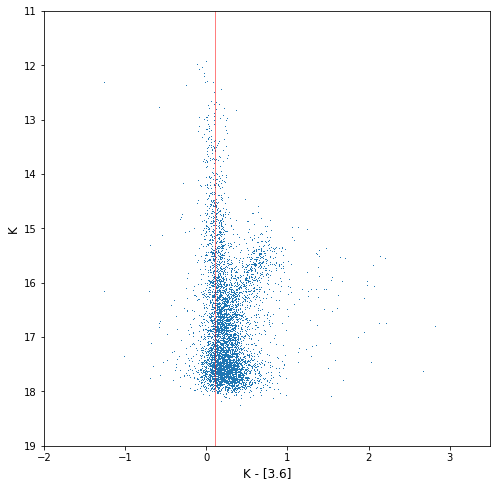

In [11]:
# K vs. K-[3.6]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSthreesix,filter_phot_data.Kmag,',')
plt.xlim(-2.0, 3.5)
plt.ylim(19.0, 11.0)
plt.xlabel('K - [3.6]', size=12)
plt.ylabel('K', size=12)
plt.axvline(x=boundary, color='r', linewidth='0.5')
#plt.savefig('K_vs_K-[3.6]_plot.pdf')

In [12]:
# Now we shift regions of the vertical mean by 3-sigma

# make list of red limit values
redlim = []

for i in e_bins:
    redlim.append(boundary+i)
    
#print(redlim)

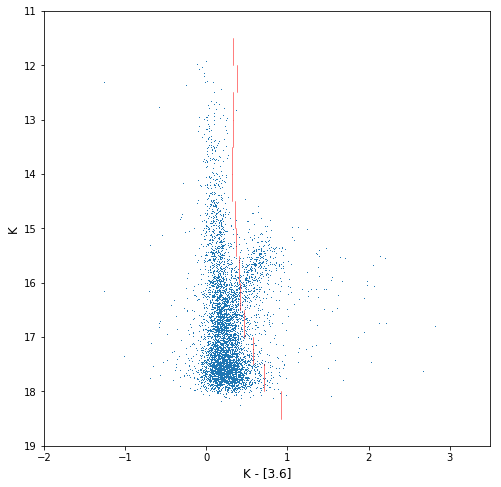

In [13]:
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSthreesix,filter_phot_data.Kmag,',')
plt.xlim(-2.0, 3.5)
plt.ylim(19.0, 11.0)
plt.xlabel('K - [3.6]', size=12)
plt.ylabel('K', size=12)

y1 = 11.5 #start of first bin range
for x in redlim:
    plt.plot((x,x), (y1, y1+0.5), c='r', linewidth='0.5')
    y1 = y1+0.5

In [14]:
# Evaluate and flag points that are to the right of the red line for that region

kMINUSthreesix_points = [] #empty set to store IDs

k=0
for i in x_bins:
    coord = c_bins[k]
    c=0
    for x in i:
        if x > redlim[k]:
            kMINUSthreesix_points.append(coord[c])
            c=c+1
        else: 
            c=c+1
    k = k+1
            
print("Number of flagged points:", len(kMINUSthreesix_points))
#print("IDs of points:", kMINUSthreesix_points)

Number of flagged points: 658


In [15]:
# Check that the points are being marked correctly

red_x = []
red_y = []

k=0
for i in x_bins:
    c=0
    y_val = y_bins[k]
    for x in i:
        if x > redlim[k]:
            red_x.append(x)
            red_y.append(y_val[c])
            c=c+1
        else: 
            c=c+1
    k = k+1

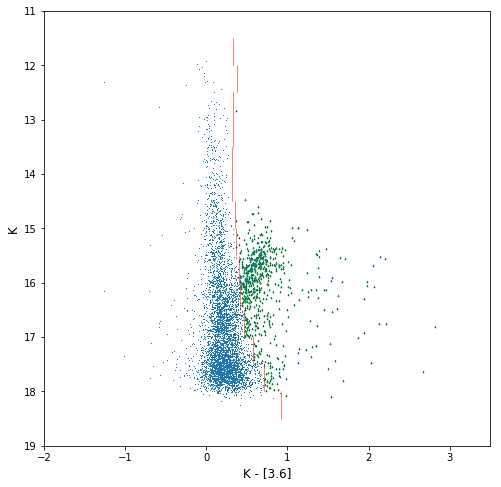

In [16]:
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSthreesix,filter_phot_data.Kmag,',')
plt.xlim(-2.0, 3.5)
plt.ylim(19.0, 11.0)
plt.xlabel('K - [3.6]', size=12)
plt.ylabel('K', size=12)
plt.scatter(red_x, red_y, s=0.5, c='green')

y1 = 11.5 #start of first bin range
for x in redlim:
    plt.plot((x,x), (y1, y1+0.5), c='r', linewidth='0.5')
    y1 = y1+0.5